# Hand Pose Estimation with Keras

## Zane Geiger

### Introduction

Hand pose estimation is a difficult problem with many potential applications in virtual reality and augmented reality. Depth information makes it a more tractable task, but there are still many challenges involved due to the high dimensionality of hand pose information, self-similarity, and self-occlusion. Recent papers have applied deep convolutional neural networks to this problem, with high levels of success. Enforcing a prior model on the hand pose further improves predictions, as well as refining joint locations using independent networks. Other have approached the problem by applying random decision forests.

Augmented and virtual reality hardware is becoming increasingly dependent on mobile architectures. Smartphones have become a cost effective way to bring virtual reality to a wider audience, using head-mounted cases such as Samsung's gear VR and Google's Daydream. Newer augmented reality devices like Microsoft's HoloLens and other untethered headsets under development also rely on smartphone hardware. Hand gestures are a natural and intuitive method of interaction in virtual and augmented reality scenarios.  Bringing gesture support to these systems without the need for bulky gloves or visual markers has the potential to expand their use cases, making them easier to use and more flexible. Gestures in augmented and virtual reality can be used to perform many actions, such as direct interaction with the virtual environment and objects, without requiring users to learn a unique set of controls for each application.

The human hand possesses several properties which make pose estimation challenging. The first is the large number of degrees of freedom; models of the hand can have from [25 to 50 degrees of freedom](data#input-images), though these models do not include joint angle constraints or the relationships between adjacent finger angles. The second is self-similarity; different fingers are difficult to distinguish, which can lead to incorrect inverse kinematics solutions. The last is self-occlusion; fingers may pass in front of one another, and the palm is concave, resulting in many parts of the hand becoming occluded and thus impossible to segment. 

On top of these inherent properties of the hand, the typical use cases for hand pose estimation introduce additional difficulties. In augmented and virtual reality applications, environmental conditions such as lighting and background color can vary wildly, compounding the difficulty of detecting hand features. Such applications may also require the tracking of hands at relatively high speeds in order to be useful, while most mobile cameras are only capable of 30 to 60 frames per second, even without taking processing speed into account. Finally, such mobile applications will be severely resource-constrained when compared to desktop or server hardware, limiting maximum frame rates and imposing a limit on latency.

Modern deep learning toolkits such as TensorFlow and Keras enable rapid prototyping of network architectures and hyperparameters. Importantly, TensorFlow makes it relatively easy to run models on low-powered hardware, providing libraries for Android and ARM devices and accelerating computations by offloading them to the mobile GPU. With this in mind, we have taken an existing approach to hand pose estimation, first introduced by Oberweger, _et al._, and created an implementation in Keras using TensorFlow as a backend.

### Existing work

Several previous papers have looked at recovering hand poses using convolutional and deep networks, and these are what I will be basing the bulk of my research on. Tompson, _et al._ were the first to use convolutional networks for this particular task, and were able to improve on existing techniques. Previous works relied on methods such as randomized decision forests (Shotton _et al._ 2011, Keskin _et al._ 2011/2012), energy minimization for model fitting (Li _et al._ 2013, Ballan _et al._ 2012), and constraint solving (Melax _et al._ 2013). More recent approaches made use of particle swarm optimization (Oikonomidis _et al._ 2011, Qian _et al._ 2014) and regression forests (Tang _et al._ 2014).

There are several hand pose datasets in existence, which typically provide a set of depth images, corresponding RGB images, and ground truth hand pose labels. The NYU dataset is one such example, consisting of 3 different viewpoints captured by Kinect sensors and ground truth poses approximated using manual labeling combined with a particle swarm based estimation algorithm. The ICVL dataset is similar, captured using a time of flight camera. The former has more pose variability but less clean depth information, while the latter has more imagery but less accurate labels. My research will depend primarily on the NYU dataset, as I will primarily be attempting to reproduce the results of Oberweger, _et al._

### Replication

This project will attempt to reproduce the results of Oberweger, _et al._ in [Hands Deep in Deep Learning for Hand Pose Estimation](https://arxiv.org/abs/1502.06807) using [Keras](https://keras.io) with the [TensorFlow](https://www.tensorflow.org/) backend using the [NYU hand pose dataset](http://cims.nyu.edu/~tompson/NYU_Hand_Pose_Dataset.htm). This initial implementation is based heavily on the work of [James Supancic](http://www.ics.uci.edu/~jsupanci/) in his [Deep Hand Pose](https://github.com/jsupancic/deep_hand_pose) project, which is implemented in the [Caffe](http://caffe.berkeleyvision.org/) framework, but is likely to diverge substantially as my research continues.

The novel approach used in Hands Deep in Deep Learning is the enforcement of a hand pose prior, which learns and incorporates constraints on the predicted hand pose, allowing the model to eliminate unlikely poses. This is implemented by reducing the dimensionality of the predicted joint locations, and then reprojecting these predictions into the original coordinate space using principal component analysis. More specifically, the penultimate layer of their neural network contains only 22 neurons, while the final layer contains 28 (2 per joint location). This initial set of predictions is used to generate a heatmap of estimated joint positions, each of which is then refined by a separately trained neural network, incorporating information from several scales for context and precision. Thus far, our network implements the first stage convolutional network, including the hand pose dimensionality reduction step.

Our reimplementation consists of two major components:

* [A data processing pipeline](data)
* [A deep learning model](model)

Each is a thoroughly documented IPython notebook, intended to be read as an integral part of this thesis, as they contain the technical information relevant to this report. The data processing script takes the NYU Hand Pose Dataset as input and produces a single [.hdf5](https://support.hdfgroup.org/HDF5/) archive, containing images and labels suitable for input to the deep learning model, performing data conversion and normalization during processing. The deep learning model builds a deep convolutional neural network, training and evaluating it on the processed dataset.

### Models

![Architecture](architecture.png)

Our baseline model was built on the architecture used by Oberweger _et al._ as reimplemented by James Supancic. Their architecture consisted of three convolutional layers, each with 8 filters of $ 5 \times 5 $ kernels. Each convolution layer uses a leaky ReLU activation function with $ \alpha = 0.05 $, and the first two convolutional layers perform $ 2 \times 2 $ max-pooling. The output from these layers is then flattened and fed into two fully connected layers of 1024 neurons, followed by 22 neurons which create the pose prior, and finally output into 28 neurons which use the frozen PCA mean and eigenvectors to reproject the predictions into joint locations.

After training a baseline implementation with similar parameters to Oberweger _et al._, we began exploring different combinations of hyperparameters to see which had the most effect on the results. In order to best compare our results to those obtained by Oberweger _et al._, we used the same performance metric. This metric was the percentage of test samples in which every predicted joint position fell within a threshold distance of the ground truth.

All models were trained on the same testing/validation split, as output by [data.ipynb](data). PCA eigenvectors and means were recomputed for certain models with differing amounts of data augmentation performed. All models were trained using the Adam optimizer solving for mean squared error, with 64 samples per batch over 100 epochs.

Data augmentation was performed on certain models to improve performance in cases where the precise hand center was not known, in order to better emulate real world conditions and make the model more robust in practical applications. However, this makes our results difficult to compare to Oberweger _et al._ Augmentation consisted of translating and scaling training samples at random within a set range. For example, an image translated over a range of size (16, 16, 0.4) may be offset by anywhere from -8 to +8 in the x and y directions and -0.2 to +0.2 in the z direction. An image scaled over a range of size (0.2, 0.2, 0.2) will be scaled by a factor of between 0.9 and 1.1 in each direction. Each image and its corresponding label must be transformed identically, and values along the edges of input images were simply repeated.

#### Baseline

This is the model contained in [model.ipynb](model). Its training data was not augmented. It has three convolutional layers, each with 12 filters using a $ 5 \times 5 $ kernel. We chose to use subsampling (striding) after each convolutional layer instead of max pooling, as used by Oberweger _et al._, over a stride length of $ 2 \times 2 $. The last convolutional layer does not perform subsampling. Each convolutional layer uses a leaky ReLU activation function with $ \alpha = 0.05 $. The final convolutional layer's output is flattened and passed into the fully connected layers. There are four fully connected layers: the first two contain 1024 neurons and use a ReLu activation function, the third contains 30 neurons, enforcing the pose prior bottleneck, and the fourth contains 42 neurons, with its bias frozen to the precomputed PCA mean and its weights frozen to the PCA eigenvectors. This final layer reprojects the model's output into the original joint space.

#### Augmented

This model is identical to the baseline, but its training data was augmented, with a scale range of (0.2, 0.2, 0.2) and a translation range of (16, 16, 0.3). Our hypothesis for this model was that it would perform worse than the baseline on the non-augmented dataset, but better on the augmented dataset, which we hope is a more accurate depiction of real world input data.

#### More PCA

This model is identical to the augmented model, but incorporates 36 components rather than the 30 used in the baseline model. For this model, we hypothesized that it would perform worse than the augmented model on the non-augmented data, but possibly better on the augmented data, since the augmented data contains additional degrees of freedom in that each joint may be offset by some factor, and these degrees of freedom would be captured in the additional PCA components in this model.

#### Deeper

This model is identical to the augmented model, but contains one additional fully conencted layer, with 1024 nodes and a ReLU activation function. We hypothesized that this model would perform better than the augmented model overall.

#### Narrow

This model is identical to the augmented model, but the fully connected layers contain only 256 neurons rather than 1024. Our hypothesis was that this model would perform worse than the augmented model.

### Results

In [1]:
from keras.models import load_model
import matplotlib.pyplot as plt
import h5py
import numpy as np
from os import path
%matplotlib inline

Using TensorFlow backend.


In [16]:
DATASET_DIR   = 'dataset'
dataset       = h5py.File(path.join(DATASET_DIR, 'dataset.hdf5'), 'r')

test_images   = dataset['image/test']
test_labels   = dataset['label/test']
test_centers  = dataset['center/test']

train_images  = dataset['image/train']
train_labels  = dataset['label/train']
train_centers = dataset['center/train']

In [3]:
models = {}

models['baseline'] = load_model('baseline.hdf5')
models['augmented'] = load_model('augmented.hdf5')
models['more_pca'] = load_model('more_pca.hdf5')
models['deeper'] = load_model('deeper.hdf5')
models['narrow'] = load_model('narrow.hdf5')

In [4]:
def uvd_to_xyz(uvd):
    normalized_x = uvd[..., 0] / 640 - 0.5
    normalized_y = 0.5 - uvd[..., 1] / 480
    
    xyz = np.zeros(uvd.shape)
    xyz[..., 2] = uvd[..., 2]
    xyz[..., 0] = normalized_x * xyz[..., 2] * 1.08836710
    xyz[..., 1] = normalized_y * xyz[..., 2] * 0.817612648
    
    return xyz

In [5]:
def denormalize(label, center):
    label = label.copy()
    
    bounds = np.array([[0, 0], [1, 1]], dtype='float')
    bounds = bounds[None, ...].repeat(len(label), 0)
    bounds -= 0.5
    bounds *= 38
    bounds *= 525 / center[..., -1, None, None]
    bounds += center[..., None, -2::-1]
    bounds = bounds.astype(int)
    
    label[..., 0:2] /= (128, 128) / (bounds[..., None, 1, :] - bounds[..., None, 0, :])
    label[..., -1] *= 15.0
    label[..., -1] += center[..., -1, None]
    
    label[..., 0:2] += bounds[..., None, 0, :]
    
    label[..., -1] *= 10
    
    return label

In [6]:
def threshold(actual, predicted, threshold):
    max_distance = np.sqrt(np.sum((actual - predicted) ** 2, -1)).max(-1)
    count = np.sum((max_distance[..., None] < threshold), axis=0)
    return count / len(max_distance)

24756/24756 [==============================] - 3s     


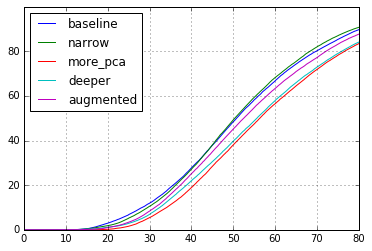

In [17]:
plt.figure()
plt.ylim([0., 100.])
plt.yticks(np.arange(0, 100, 20))
plt.grid()

for model_name, model in models.items():
    predictions = model.predict(test_images, 64, 1)
    
    error = threshold(
        uvd_to_xyz(denormalize(test_labels[:].reshape(-1, 14, 3), test_centers[:])),
        uvd_to_xyz(denormalize(predictions.reshape(-1, 14, 3), test_centers[:])),
        np.linspace(0, 80, 1000)
    )
    
    del predictions
    plt.plot(np.linspace(0, 80, 1000), error * 100, label=model_name)
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))

#### Non-augmented test data

As we can see, the baseline implementation is just about the best overall. This is most likely because the evaluation data is not augmented. As we predicted, the more_pca model performed the worst here. Interestingly, however, the deeper network performed the second worst, while the narrower network performed the best. We suspect this is due to the larger networks having a tendency to overfit and 'memorize' the dataset to a greater degree. Finally, the baseline network trained on augmented data performed slightly worse than the baseline on the non-augmented dataset.

In [8]:
import scipy.misc
import math
import random

In [9]:
# Resize an image to the specified dimensions, scaling its label accordingly
def resize(image, label, dimensions):
    scale        = np.array(dimensions) / image.shape[:-1]
    label[::3]  *= scale[1]
    label[1::3] *= scale[0]
    
    # TODO: Try to implement or use OpenCV's INTER_AREA resize strategy?
    image = scipy.misc.imresize(np.squeeze(image), dimensions, 'bilinear', mode='F')
    
    return image, label

In [10]:
# Clip an image to the specified bounding box, translating its label accordingly
# Bounding box should look like np.array([[x_1, y_1], [x_2, y_2]]), where
# (x_1, y_1) are the coordinates of the lower left corner and 
# (x_2, y_2) are the coordinates of the upper right corner
def clip(image, label, bounding_box):
    label[::3]  -= bounding_box[0, 1]
    label[1::3] -= bounding_box[0, 0]
    
    image_box = np.array([[0, 0], image.shape[:-1]], dtype='int')
    
    padding = np.array([image_box[0] - bounding_box[0], bounding_box[1] - image_box[1]]).clip(0)
    bounding_box += padding[0]
    padding = np.concatenate((padding.T, np.array([[0, 0]])))
    
    image = np.pad(image, padding, 'edge')
    image = image[slice(*bounding_box[:, 0]), slice(*bounding_box[:, 1])]
    
    return image, label

In [26]:
def augment(image, label, center, scale_range=np.zeros(3), translate_range=np.zeros(3)):
    image  = image.copy()
    label  = label.copy()
    center = center.copy()
    
    scale = 1 + (np.random.random(3) - 0.5) * scale_range
    translate = (np.random.random(3) - 0.5) * translate_range
    
    bounds = np.array([[0, 0], [1, 1]], dtype='float')
    bounds -= 0.5
    bounds *= image.shape[:-1]
    bounds /= scale[:-1]
    bounds += 64
    bounds -= translate[:-1]
    bounds = bounds.astype(int)
    
    image, label = clip(image, label, bounds)
    image[image != 1] /= scale[-1]
    image[image != 1] += translate[-1]
    label[2::3] /= scale[-1]
    label[2::3] += translate[-1]
    image = np.clip(image, -1, 1)
    
    center[::3]  -= bounds[0, 1]
    center[1::3] -= bounds[0, 0]
    scale         = np.array([128, 128]) / image.shape[:-1]
    center[::3]  *= scale[1]
    center[1::3] *= scale[0]
    
    image, label = resize(image, label, (128, 128))
    image = np.expand_dims(image, 2)
    
    return image, label, center

In [27]:
def augment_batch(image_batch, label_batch, center_batch, scale_range=np.zeros(3), translate_range=np.zeros(3)):
    image_batch, label_batch, center_batch = zip(*[augment(image, label, center, scale_range, translate_range) \
                                     for image, label, center in zip(image_batch, label_batch, center_batch)])
    
    return np.array(image_batch), np.array(label_batch), np.array(center_batch)

In [30]:
augmented_test_images, augmented_test_labels, augmented_test_centers = augment_batch(test_images, test_labels, test_centers, (0.2, 0.2, 0.2), (16, 16, 0.3))

24756/24756 [==============================] - 2s     


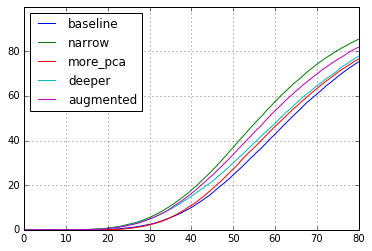

In [31]:
plt.figure()
plt.ylim([0., 100.])
plt.yticks(np.arange(0, 100, 20))
plt.grid()

for model_name, model in models.items():
    predictions = model.predict(augmented_test_images, 64, 1)
    
    error = threshold(
        uvd_to_xyz(denormalize(augmented_test_labels[:].reshape(-1, 14, 3), augmented_test_centers[:])),
        uvd_to_xyz(denormalize(predictions.reshape(-1, 14, 3), augmented_test_centers[:])),
        np.linspace(0, 80, 1000)
    )
    
    del predictions
    plt.plot(np.linspace(0, 80, 1000), error * 100, label=model_name)
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))

#### Augmented test data

When tested on augmented data, we can see that the baseline implementation performed the worst, as predicted. The baseline network trained on augmented data did significantly better in this test. The more_pca model did not perform as well as expected here. Most surprisingly, the narrow network outperformed the rest, while the deeper network had degraded performance. Again, we surmise that this is due to overfitting the training data.

### Conclusions

Overall, we succeeded in reimplementing the first stage of the architecture proposed by Oberweger _et al._ Our results were slightly inferior, and a great deal of experimentation with the data preprocessing step was involved in achieving correct results. In general, being careful to process data correctly had a much greater impact of network performance than hyperparameter tuning.

Furthermore, overfitting the dataset appears to be a bigger potential problem than underfitting. We infer this based on the results shown by our deeper and narrower networks. In particular, the deeper network consistently performed worse than our baseline, while the narrower network consistently performed better, somewhat counterintuitively. Additional data could possibly have reversed this trend.

### Future Work

Architectural tuning and combinations of specialized networks have produced impressive results in the past, and there are many opportunities for further improvement. One interesting possibility is the use of autoencoders to learn a better pose prior than PCA can produce. Autoencoders perform a function similar to PCA, compressing high-dimensional data to as few dimensions as possible without loss of information. Nonlinear, regularized, or deep autoencoders may be capable of learning more useful correlations within the data and therefore produce a more accurate hand pose prior.

Hyperparameter tuning is also a task which can itself be learned through reinforcement learning, genetic algorithms, and other methods. The best networks would seem to be those which minimize overfitting while maximizing accuracy, which implies that the optimal network should be as small as possible before accuracy is sacrificed for generality. Combinations of more specialized networks, such as the refinement step shown to be effective by Oberweger _et al._, certainly warrant further study.

Finally, using these networks for inference in real world applications still poses unique challenges. Many potential applications have stringent power and complexity requirements. Porting a network to such an environment may require trading accuracy for speed and power consumption. Fortunately, weight quantization and network minimization techniques can be applied to reduce the resources needed for inference without significantly impacting accuracy of predictions.